# NN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from tqdm.autonotebook import tqdm

/tmp/ipykernel_5314/38736474.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Загрузка матрицы признаков
feature_matrix =  pd.read_csv('feature_matrix_128.csv', na_values=["?"])
total_matrix = feature_matrix.copy()

total_matrix = feature_matrix.drop(columns = ['Unnamed: 0'])
total_matrix.head()

,Ax_MAV,Ax_CD,Ax_MAX,Ax_MIN,Ax_INIT,Ax_FNL,Ay_MAV,Ay_CD,Ay_MAX,Ay_MIN,...,RF_IEMG,RF_MAV,RF_LOG,RF_WL,RF_ACC,RF_DASDV,RF_ZC,RF_WAMP,RF_MYOP,Mode
0,-0.082788,0.194516,0.098621,-0.553145,-0.548947,-0.006729,0.193257,0.105025,0.482086,0.086829,...,0.659565,0.002199,0.057953,0.369797,0.001233,0.001564,52.0,0.0,0.0,0.0
1,-0.147134,0.218421,0.104413,-0.572925,-0.035088,0.104413,0.229532,0.130144,0.504380,0.085965,...,0.584493,0.001948,0.056085,0.381330,0.001271,0.001618,64.0,0.0,0.0,0.0
2,-0.095318,0.186721,0.104413,-0.572925,0.038609,-0.461041,0.214915,0.111148,0.504380,0.085965,...,0.543723,0.001812,0.054427,0.403360,0.001345,0.001724,74.0,0.0,0.0,0.0
3,-0.072635,0.191764,0.104413,-0.585118,-0.343078,-0.001161,0.194778,0.117547,0.532462,0.081685,...,0.564877,0.001883,0.055629,0.378346,0.001261,0.001626,59.0,0.0,0.0,0.0
4,-0.164038,0.216013,0.100683,-0.585118,-0.002821,-0.013294,0.248497,0.134200,0.532462,0.075260,...,0.543924,0.001813,0.054203,0.387581,0.001292,0.001632,61.0,0.0,0.0,0.0


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
x_raw = total_matrix.copy()
y = x_raw['Mode']
x_raw = x_raw.copy().drop(columns=['Mode'])
rus = RandomUnderSampler()
x_raw, y = rus.fit_resample(x_raw, y)
print(x_raw[y==0].shape)
print(x_raw[y==1].shape)
X_train, X_test, y_train, y_test = train_test_split(x_raw, y, test_size=0.2, random_state=42)
normalizer = preprocessing.StandardScaler()
X_train = pd.DataFrame(normalizer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(normalizer.fit_transform(X_test), columns=X_test.columns)

(3585, 92)
(3585, 92)


In [5]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [6]:
class FeatureDataset(Dataset):
  def __init__(self, data, targets, transform=None):
      self.data = torch.Tensor(data)
      self.targets = torch.LongTensor(targets)
      self.transform = transform

  def __getitem__(self, index):
      x = self.data[index]
      y = self.targets[index]
      return x, y

  def __len__(self):
      return len(self.data)

In [7]:
train_dataset=FeatureDataset(X_train.to_numpy(),y_train.to_numpy())
test_dataset=FeatureDataset(X_test.to_numpy(),y_test.to_numpy())

In [8]:
train_dataset[0]

(tensor([-1.0843,  0.9503,  0.4715, -0.7292, -0.1371, -0.6281,  0.4656,  1.4930,
          1.7980, -1.2059,  0.9249, -0.1410, -0.6311,  1.5475,  1.1657, -1.1153,
          2.2137, -0.9988,  0.6507, -0.2457,  0.4002,  0.3761,  0.6051,  1.0191,
         -0.4134,  0.1667, -0.2192, -0.0808,  0.2081, -0.8107, -0.1485, -0.1077,
         -0.2517,  0.0163, -0.1328,  0.4684,  0.5166,  0.0137,  0.5923,  0.6625,
          0.9239,  0.2709, -0.6554,  0.0431, -0.2092, -0.6327,  0.5849,  0.3674,
         -0.0127,  0.4529,  0.5218,  0.5218,  0.9626,  0.6484,  0.6484,  0.5636,
          0.4892,  0.2278,  0.5894, -0.3119, -0.7015, -0.7447, -0.7447, -0.7741,
         -0.6501, -0.6501, -0.6392, -0.0137, -0.5339, -0.5433,  0.1034,  0.6949,
          0.7315,  0.7315,  1.1348,  0.6175,  0.6175,  0.5656, -0.9225, -0.3849,
         -0.4935,  0.0334,  0.7990,  0.9932,  0.9932,  1.2977,  0.9733,  0.9733,
          0.8226, -0.3668, -0.2657, -0.5038]),
 tensor(5))

In [9]:
batch_size=150# размер пакета
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
dataloaders = {"train": train_loader,"validation": test_loader}

In [10]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [11]:
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self, num_inputs, num_classes):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
        nn.Linear(num_inputs, 184),
        nn.LeakyReLU(),
        nn.Linear(184, 184),
        nn.LeakyReLU(),
        nn.Linear(184, 25),
        nn.LeakyReLU(),
        nn.Linear(25, num_classes)
    )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model=NeuralNetwork(92,7)
print(model.to(device))


NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=92, out_features=184, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=184, out_features=184, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=184, out_features=25, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=25, out_features=7, bias=True)
  )
)


In [12]:
from torchinfo import summary
summary(model,input_size=(1,92))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 7]                    --
├─Sequential: 1-1                        [1, 7]                    --
│    └─Linear: 2-1                       [1, 184]                  17,112
│    └─LeakyReLU: 2-2                    [1, 184]                  --
│    └─Linear: 2-3                       [1, 184]                  34,040
│    └─LeakyReLU: 2-4                    [1, 184]                  --
│    └─Linear: 2-5                       [1, 25]                   4,625
│    └─LeakyReLU: 2-6                    [1, 25]                   --
│    └─Linear: 2-7                       [1, 7]                    182
Total params: 55,959
Trainable params: 55,959
Non-trainable params: 0
Total mult-adds (M): 0.06
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.22
Estimated Total Size (MB): 0.23

In [13]:
optimizer = optim.Adam(model.parameters(), lr = 0.00005)
criterion = nn.CrossEntropyLoss()

In [14]:
!pip install pytorch-ignite --quiet

In [15]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

In [16]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [17]:
metrics = { "loss" : Loss(criterion), 
           "accuracy" : Accuracy(),
            "cm": ConfusionMatrix(num_classes=7)}

In [18]:
train_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)
test_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)

In [19]:
training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [20]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [21]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [22]:
#breaker = EarlyStopping(patience = 20, score_function = lambda engine : engine.state.metrics['accuracy'],
#                       trainer = trainer)
#test_evaluator.add_event_handler(Events.COMPLETED, breaker);

In [23]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=2, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

In [24]:
from tqdm.autonotebook import tqdm
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

In [25]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = ['Сидение', 'Ходьба по ровной поверхности', 'Поднятие по рампе', 'Спуск по рампе', 'Поднятие по лестнице', 'Спуск по лестнице', 'Стояние']
    fig, ax = plt.subplots(figsize=(5,5))  
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Предсказанные классы')
    ax.set_ylabel('Реальные классы') 
    ax.set_title('Матрица ошибок') 
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 1  Сред. точность: 44.79 Сред. ошибка: 1.81472
Результат валидации - Эпоха: 1  Сред. точность: 45.29 Сред. ошибка: 1.81538


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 2  Сред. точность: 50.10 Сред. ошибка: 1.51570
Результат валидации - Эпоха: 2  Сред. точность: 50.23 Сред. ошибка: 1.51616


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 3  Сред. точность: 55.17 Сред. ошибка: 1.29548
Результат валидации - Эпоха: 3  Сред. точность: 54.47 Сред. ошибка: 1.29874


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 4  Сред. точность: 60.32 Сред. ошибка: 1.15591
Результат валидации - Эпоха: 4  Сред. точность: 59.73 Сред. ошибка: 1.15952


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 5  Сред. точность: 64.34 Сред. ошибка: 1.04393
Результат валидации - Эпоха: 5  Сред. точность: 63.92 Сред. ошибка: 1.04749


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 6  Сред. точность: 68.54 Сред. ошибка: 0.94872
Результат валидации - Эпоха: 6  Сред. точность: 67.76 Сред. ошибка: 0.95309


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 7  Сред. точность: 71.58 Сред. ошибка: 0.87239
Результат валидации - Эпоха: 7  Сред. точность: 71.21 Сред. ошибка: 0.87803


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 8  Сред. точность: 73.65 Сред. ошибка: 0.81270
Результат валидации - Эпоха: 8  Сред. точность: 73.34 Сред. ошибка: 0.81977


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 9  Сред. точность: 75.42 Сред. ошибка: 0.76547
Результат валидации - Эпоха: 9  Сред. точность: 75.07 Сред. ошибка: 0.77426


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 10  Сред. точность: 76.65 Сред. ошибка: 0.72708
Результат валидации - Эпоха: 10  Сред. точность: 76.45 Сред. ошибка: 0.73630


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 11  Сред. точность: 77.82 Сред. ошибка: 0.69379
Результат валидации - Эпоха: 11  Сред. точность: 77.23 Сред. ошибка: 0.70404


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 12  Сред. точность: 78.99 Сред. ошибка: 0.66526
Результат валидации - Эпоха: 12  Сред. точность: 78.46 Сред. ошибка: 0.67685


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 13  Сред. точность: 79.73 Сред. ошибка: 0.63994
Результат валидации - Эпоха: 13  Сред. точность: 79.56 Сред. ошибка: 0.65291


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 14  Сред. точность: 80.50 Сред. ошибка: 0.61807
Результат валидации - Эпоха: 14  Сред. точность: 80.06 Сред. ошибка: 0.63194


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 15  Сред. точность: 81.19 Сред. ошибка: 0.59764
Результат валидации - Эпоха: 15  Сред. точность: 80.77 Сред. ошибка: 0.61337


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 16  Сред. точность: 81.81 Сред. ошибка: 0.57929
Результат валидации - Эпоха: 16  Сред. точность: 81.51 Сред. ошибка: 0.59583


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 17  Сред. точность: 82.27 Сред. ошибка: 0.56281
Результат валидации - Эпоха: 17  Сред. точность: 82.05 Сред. ошибка: 0.58004


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 18  Сред. точность: 82.78 Сред. ошибка: 0.54795
Результат валидации - Эпоха: 18  Сред. точность: 82.19 Сред. ошибка: 0.56717


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 19  Сред. точность: 83.40 Сред. ошибка: 0.53379
Результат валидации - Эпоха: 19  Сред. точность: 82.96 Сред. ошибка: 0.55368


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 20  Сред. точность: 84.00 Сред. ошибка: 0.52034
Результат валидации - Эпоха: 20  Сред. точность: 83.18 Сред. ошибка: 0.54224


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 21  Сред. точность: 84.30 Сред. ошибка: 0.50883
Результат валидации - Эпоха: 21  Сред. точность: 83.42 Сред. ошибка: 0.53165


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 22  Сред. точность: 84.65 Сред. ошибка: 0.49735
Результат валидации - Эпоха: 22  Сред. точность: 83.46 Сред. ошибка: 0.52181


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 23  Сред. точность: 85.11 Сред. ошибка: 0.48708
Результат валидации - Эпоха: 23  Сред. точность: 84.16 Сред. ошибка: 0.51336


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 24  Сред. точность: 85.31 Сред. ошибка: 0.47767
Результат валидации - Эпоха: 24  Сред. точность: 83.84 Сред. ошибка: 0.50465


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 25  Сред. точность: 85.67 Сред. ошибка: 0.46762
Результат валидации - Эпоха: 25  Сред. точность: 84.36 Сред. ошибка: 0.49631


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 26  Сред. точность: 85.88 Сред. ошибка: 0.45891
Результат валидации - Эпоха: 26  Сред. точность: 84.46 Сред. ошибка: 0.48961


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 27  Сред. точность: 86.17 Сред. ошибка: 0.45102
Результат валидации - Эпоха: 27  Сред. точность: 84.58 Сред. ошибка: 0.48317


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 28  Сред. точность: 86.43 Сред. ошибка: 0.44318
Результат валидации - Эпоха: 28  Сред. точность: 84.92 Сред. ошибка: 0.47645


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 29  Сред. точность: 86.63 Сред. ошибка: 0.43598
Результат валидации - Эпоха: 29  Сред. точность: 84.82 Сред. ошибка: 0.47056


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 30  Сред. точность: 86.98 Сред. ошибка: 0.42927
Результат валидации - Эпоха: 30  Сред. точность: 85.16 Сред. ошибка: 0.46558


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 31  Сред. точность: 87.15 Сред. ошибка: 0.42230
Результат валидации - Эпоха: 31  Сред. точность: 85.26 Сред. ошибка: 0.46011


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 32  Сред. точность: 87.39 Сред. ошибка: 0.41605
Результат валидации - Эпоха: 32  Сред. точность: 85.48 Сред. ошибка: 0.45523


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 33  Сред. точность: 87.41 Сред. ошибка: 0.41000
Результат валидации - Эпоха: 33  Сред. точность: 85.53 Сред. ошибка: 0.44922


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 34  Сред. точность: 87.60 Сред. ошибка: 0.40443
Результат валидации - Эпоха: 34  Сред. точность: 85.77 Сред. ошибка: 0.44594


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 35  Сред. точность: 87.84 Сред. ошибка: 0.40010
Результат валидации - Эпоха: 35  Сред. точность: 85.69 Сред. ошибка: 0.44225


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 36  Сред. точность: 87.93 Сред. ошибка: 0.39380
Результат валидации - Эпоха: 36  Сред. точность: 85.87 Сред. ошибка: 0.43827


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 37  Сред. точность: 88.10 Сред. ошибка: 0.39002
Результат валидации - Эпоха: 37  Сред. точность: 85.87 Сред. ошибка: 0.43524


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 38  Сред. точность: 88.31 Сред. ошибка: 0.38492
Результат валидации - Эпоха: 38  Сред. точность: 86.15 Сред. ошибка: 0.43043


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 39  Сред. точность: 88.49 Сред. ошибка: 0.38052
Результат валидации - Эпоха: 39  Сред. точность: 86.23 Сред. ошибка: 0.42780


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 40  Сред. точность: 88.58 Сред. ошибка: 0.37563
Результат валидации - Эпоха: 40  Сред. точность: 86.27 Сред. ошибка: 0.42433


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 41  Сред. точность: 88.66 Сред. ошибка: 0.37162
Результат валидации - Эпоха: 41  Сред. точность: 86.33 Сред. ошибка: 0.42077


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 42  Сред. точность: 88.69 Сред. ошибка: 0.36800
Результат валидации - Эпоха: 42  Сред. точность: 86.67 Сред. ошибка: 0.41922


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 43  Сред. точность: 88.90 Сред. ошибка: 0.36336
Результат валидации - Эпоха: 43  Сред. точность: 86.71 Сред. ошибка: 0.41615


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 44  Сред. точность: 89.00 Сред. ошибка: 0.35975
Результат валидации - Эпоха: 44  Сред. точность: 86.81 Сред. ошибка: 0.41176


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 45  Сред. точность: 89.11 Сред. ошибка: 0.35581
Результат валидации - Эпоха: 45  Сред. точность: 86.81 Сред. ошибка: 0.40973


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 46  Сред. точность: 89.07 Сред. ошибка: 0.35337
Результат валидации - Эпоха: 46  Сред. точность: 86.79 Сред. ошибка: 0.40866


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 47  Сред. точность: 89.15 Сред. ошибка: 0.34974
Результат валидации - Эпоха: 47  Сред. точность: 86.97 Сред. ошибка: 0.40541


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 48  Сред. точность: 89.53 Сред. ошибка: 0.34624
Результат валидации - Эпоха: 48  Сред. точность: 87.01 Сред. ошибка: 0.40326


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 49  Сред. точность: 89.48 Сред. ошибка: 0.34251
Результат валидации - Эпоха: 49  Сред. точность: 87.17 Сред. ошибка: 0.40095


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 50  Сред. точность: 89.46 Сред. ошибка: 0.33965
Результат валидации - Эпоха: 50  Сред. точность: 87.27 Сред. ошибка: 0.39856


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 51  Сред. точность: 89.61 Сред. ошибка: 0.33647
Результат валидации - Эпоха: 51  Сред. точность: 87.15 Сред. ошибка: 0.39767


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 52  Сред. точность: 89.85 Сред. ошибка: 0.33361
Результат валидации - Эпоха: 52  Сред. точность: 87.35 Сред. ошибка: 0.39391


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 53  Сред. точность: 89.92 Сред. ошибка: 0.33112
Результат валидации - Эпоха: 53  Сред. точность: 87.31 Сред. ошибка: 0.39270


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 54  Сред. точность: 89.99 Сред. ошибка: 0.32876
Результат валидации - Эпоха: 54  Сред. точность: 87.57 Сред. ошибка: 0.39143


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 55  Сред. точность: 90.07 Сред. ошибка: 0.32652
Результат валидации - Эпоха: 55  Сред. точность: 87.29 Сред. ошибка: 0.39154


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 56  Сред. точность: 90.14 Сред. ошибка: 0.32361
Результат валидации - Эпоха: 56  Сред. точность: 87.73 Сред. ошибка: 0.38920


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 57  Сред. точность: 90.24 Сред. ошибка: 0.31970
Результат валидации - Эпоха: 57  Сред. точность: 87.59 Сред. ошибка: 0.38591


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 58  Сред. точность: 90.30 Сред. ошибка: 0.31814
Результат валидации - Эпоха: 58  Сред. точность: 87.73 Сред. ошибка: 0.38497


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 59  Сред. точность: 90.35 Сред. ошибка: 0.31470
Результат валидации - Эпоха: 59  Сред. точность: 87.57 Сред. ошибка: 0.38244


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 60  Сред. точность: 90.40 Сред. ошибка: 0.31230
Результат валидации - Эпоха: 60  Сред. точность: 87.75 Сред. ошибка: 0.38185


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 61  Сред. точность: 90.51 Сред. ошибка: 0.31025
Результат валидации - Эпоха: 61  Сред. точность: 87.79 Сред. ошибка: 0.37892


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 62  Сред. точность: 90.64 Сред. ошибка: 0.30751
Результат валидации - Эпоха: 62  Сред. точность: 87.87 Сред. ошибка: 0.37746


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 63  Сред. точность: 90.62 Сред. ошибка: 0.30522
Результат валидации - Эпоха: 63  Сред. точность: 87.71 Сред. ошибка: 0.37711


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 64  Сред. точность: 90.71 Сред. ошибка: 0.30277
Результат валидации - Эпоха: 64  Сред. точность: 87.83 Сред. ошибка: 0.37487


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 65  Сред. точность: 90.87 Сред. ошибка: 0.30082
Результат валидации - Эпоха: 65  Сред. точность: 88.03 Сред. ошибка: 0.37483


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 66  Сред. точность: 90.83 Сред. ошибка: 0.29831
Результат валидации - Эпоха: 66  Сред. точность: 87.91 Сред. ошибка: 0.37245


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 67  Сред. точность: 90.95 Сред. ошибка: 0.29677
Результат валидации - Эпоха: 67  Сред. точность: 88.01 Сред. ошибка: 0.37179


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 68  Сред. точность: 90.95 Сред. ошибка: 0.29481
Результат валидации - Эпоха: 68  Сред. точность: 87.97 Сред. ошибка: 0.37068


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 69  Сред. точность: 91.01 Сред. ошибка: 0.29298
Результат валидации - Эпоха: 69  Сред. точность: 88.11 Сред. ошибка: 0.36847


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 70  Сред. точность: 91.09 Сред. ошибка: 0.29084
Результат валидации - Эпоха: 70  Сред. точность: 88.24 Сред. ошибка: 0.36840


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 71  Сред. точность: 91.11 Сред. ошибка: 0.28888
Результат валидации - Эпоха: 71  Сред. точность: 88.05 Сред. ошибка: 0.36689


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 72  Сред. точность: 91.18 Сред. ошибка: 0.28621
Результат валидации - Эпоха: 72  Сред. точность: 88.28 Сред. ошибка: 0.36607


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 73  Сред. точность: 91.30 Сред. ошибка: 0.28434
Результат валидации - Эпоха: 73  Сред. точность: 88.34 Сред. ошибка: 0.36475


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 74  Сред. точность: 91.29 Сред. ошибка: 0.28410
Результат валидации - Эпоха: 74  Сред. точность: 88.42 Сред. ошибка: 0.36359


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 75  Сред. точность: 91.48 Сред. ошибка: 0.28083
Результат валидации - Эпоха: 75  Сред. точность: 88.32 Сред. ошибка: 0.36320


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 76  Сред. точность: 91.43 Сред. ошибка: 0.27915
Результат валидации - Эпоха: 76  Сред. точность: 88.42 Сред. ошибка: 0.36293


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 77  Сред. точность: 91.54 Сред. ошибка: 0.27692
Результат валидации - Эпоха: 77  Сред. точность: 88.42 Сред. ошибка: 0.36016


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 78  Сред. точность: 91.65 Сред. ошибка: 0.27514
Результат валидации - Эпоха: 78  Сред. точность: 88.50 Сред. ошибка: 0.35936


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 79  Сред. точность: 91.70 Сред. ошибка: 0.27325
Результат валидации - Эпоха: 79  Сред. точность: 88.46 Сред. ошибка: 0.35826


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 80  Сред. точность: 91.72 Сред. ошибка: 0.27209
Результат валидации - Эпоха: 80  Сред. точность: 88.44 Сред. ошибка: 0.35936


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 81  Сред. точность: 91.72 Сред. ошибка: 0.26984
Результат валидации - Эпоха: 81  Сред. точность: 88.64 Сред. ошибка: 0.35656


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 82  Сред. точность: 91.77 Сред. ошибка: 0.26881
Результат валидации - Эпоха: 82  Сред. точность: 88.54 Сред. ошибка: 0.35674


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 83  Сред. точность: 91.90 Сред. ошибка: 0.26679
Результат валидации - Эпоха: 83  Сред. точность: 88.60 Сред. ошибка: 0.35456


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 84  Сред. точность: 91.92 Сред. ошибка: 0.26590
Результат валидации - Эпоха: 84  Сред. точность: 88.68 Сред. ошибка: 0.35336


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 85  Сред. точность: 92.01 Сред. ошибка: 0.26331
Результат валидации - Эпоха: 85  Сред. точность: 88.74 Сред. ошибка: 0.35231


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 86  Сред. точность: 92.04 Сред. ошибка: 0.26200
Результат валидации - Эпоха: 86  Сред. точность: 88.52 Сред. ошибка: 0.35347


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 87  Сред. точность: 91.96 Сред. ошибка: 0.26102
Результат валидации - Эпоха: 87  Сред. точность: 88.74 Сред. ошибка: 0.35159


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 88  Сред. точность: 92.11 Сред. ошибка: 0.25870
Результат валидации - Эпоха: 88  Сред. точность: 88.76 Сред. ошибка: 0.35044


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 89  Сред. точность: 92.18 Сред. ошибка: 0.25740
Результат валидации - Эпоха: 89  Сред. точность: 88.64 Сред. ошибка: 0.35030


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 90  Сред. точность: 92.23 Сред. ошибка: 0.25611
Результат валидации - Эпоха: 90  Сред. точность: 88.66 Сред. ошибка: 0.34971


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 91  Сред. точность: 92.16 Сред. ошибка: 0.25514
Результат валидации - Эпоха: 91  Сред. точность: 88.66 Сред. ошибка: 0.34857


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 92  Сред. точность: 92.22 Сред. ошибка: 0.25334
Результат валидации - Эпоха: 92  Сред. точность: 88.76 Сред. ошибка: 0.34894


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 93  Сред. точность: 92.31 Сред. ошибка: 0.25214
Результат валидации - Эпоха: 93  Сред. точность: 88.56 Сред. ошибка: 0.34919


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 94  Сред. точность: 92.38 Сред. ошибка: 0.25104
Результат валидации - Эпоха: 94  Сред. точность: 88.70 Сред. ошибка: 0.34643


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 95  Сред. точность: 92.39 Сред. ошибка: 0.24891
Результат валидации - Эпоха: 95  Сред. точность: 88.78 Сред. ошибка: 0.34622


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 96  Сред. точность: 92.42 Сред. ошибка: 0.24794
Результат валидации - Эпоха: 96  Сред. точность: 88.88 Сред. ошибка: 0.34581


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 97  Сред. точность: 92.45 Сред. ошибка: 0.24629
Результат валидации - Эпоха: 97  Сред. точность: 88.82 Сред. ошибка: 0.34454


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 98  Сред. точность: 92.51 Сред. ошибка: 0.24506
Результат валидации - Эпоха: 98  Сред. точность: 88.86 Сред. ошибка: 0.34553


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 99  Сред. точность: 92.59 Сред. ошибка: 0.24380
Результат валидации - Эпоха: 99  Сред. точность: 88.86 Сред. ошибка: 0.34334


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 100  Сред. точность: 92.48 Сред. ошибка: 0.24323
Результат валидации - Эпоха: 100  Сред. точность: 88.88 Сред. ошибка: 0.34464


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 101  Сред. точность: 92.64 Сред. ошибка: 0.24068
Результат валидации - Эпоха: 101  Сред. точность: 88.92 Сред. ошибка: 0.34231


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 102  Сред. точность: 92.73 Сред. ошибка: 0.24036
Результат валидации - Эпоха: 102  Сред. точность: 88.92 Сред. ошибка: 0.34397


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 103  Сред. точность: 92.71 Сред. ошибка: 0.23884
Результат валидации - Эпоха: 103  Сред. точность: 88.88 Сред. ошибка: 0.34153


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 104  Сред. точность: 92.82 Сред. ошибка: 0.23695
Результат валидации - Эпоха: 104  Сред. точность: 89.16 Сред. ошибка: 0.34173


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 105  Сред. точность: 92.84 Сред. ошибка: 0.23597
Результат валидации - Эпоха: 105  Сред. точность: 88.82 Сред. ошибка: 0.34170


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 106  Сред. точность: 92.82 Сред. ошибка: 0.23482
Результат валидации - Эпоха: 106  Сред. точность: 89.10 Сред. ошибка: 0.34106


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 107  Сред. точность: 92.96 Сред. ошибка: 0.23405
Результат валидации - Эпоха: 107  Сред. точность: 88.92 Сред. ошибка: 0.34239


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 108  Сред. точность: 92.96 Сред. ошибка: 0.23193
Результат валидации - Эпоха: 108  Сред. точность: 89.16 Сред. ошибка: 0.33926


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 109  Сред. точность: 92.98 Сред. ошибка: 0.23195
Результат валидации - Эпоха: 109  Сред. точность: 88.98 Сред. ошибка: 0.33896


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 110  Сред. точность: 93.05 Сред. ошибка: 0.23000
Результат валидации - Эпоха: 110  Сред. точность: 89.04 Сред. ошибка: 0.33918


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 111  Сред. точность: 93.05 Сред. ошибка: 0.22922
Результат валидации - Эпоха: 111  Сред. точность: 89.16 Сред. ошибка: 0.33714


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 112  Сред. точность: 93.16 Сред. ошибка: 0.22718
Результат валидации - Эпоха: 112  Сред. точность: 89.26 Сред. ошибка: 0.33718


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 113  Сред. точность: 93.16 Сред. ошибка: 0.22658
Результат валидации - Эпоха: 113  Сред. точность: 89.20 Сред. ошибка: 0.33792


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 114  Сред. точность: 93.16 Сред. ошибка: 0.22658
Результат валидации - Эпоха: 114  Сред. точность: 89.24 Сред. ошибка: 0.33661


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 115  Сред. точность: 93.23 Сред. ошибка: 0.22413
Результат валидации - Эпоха: 115  Сред. точность: 89.24 Сред. ошибка: 0.33567


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 116  Сред. точность: 93.28 Сред. ошибка: 0.22311
Результат валидации - Эпоха: 116  Сред. точность: 89.24 Сред. ошибка: 0.33615


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 117  Сред. точность: 93.34 Сред. ошибка: 0.22179
Результат валидации - Эпоха: 117  Сред. точность: 89.12 Сред. ошибка: 0.33440


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 118  Сред. точность: 93.38 Сред. ошибка: 0.22089
Результат валидации - Эпоха: 118  Сред. точность: 89.28 Сред. ошибка: 0.33614


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 119  Сред. точность: 93.44 Сред. ошибка: 0.21977
Результат валидации - Эпоха: 119  Сред. точность: 89.32 Сред. ошибка: 0.33481


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 120  Сред. точность: 93.42 Сред. ошибка: 0.21901
Результат валидации - Эпоха: 120  Сред. точность: 89.28 Сред. ошибка: 0.33612


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 121  Сред. точность: 93.47 Сред. ошибка: 0.21805
Результат валидации - Эпоха: 121  Сред. точность: 89.20 Сред. ошибка: 0.33745


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 122  Сред. точность: 93.51 Сред. ошибка: 0.21707
Результат валидации - Эпоха: 122  Сред. точность: 89.48 Сред. ошибка: 0.33556


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 123  Сред. точность: 93.54 Сред. ошибка: 0.21626
Результат валидации - Эпоха: 123  Сред. точность: 89.22 Сред. ошибка: 0.33374


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 124  Сред. точность: 93.54 Сред. ошибка: 0.21451
Результат валидации - Эпоха: 124  Сред. точность: 89.22 Сред. ошибка: 0.33323


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 125  Сред. точность: 93.61 Сред. ошибка: 0.21358
Результат валидации - Эпоха: 125  Сред. точность: 89.44 Сред. ошибка: 0.33336


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 126  Сред. точность: 93.60 Сред. ошибка: 0.21305
Результат валидации - Эпоха: 126  Сред. точность: 89.42 Сред. ошибка: 0.33433


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 127  Сред. точность: 93.70 Сред. ошибка: 0.21205
Результат валидации - Эпоха: 127  Сред. точность: 89.20 Сред. ошибка: 0.33456


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 128  Сред. точность: 93.73 Сред. ошибка: 0.21043
Результат валидации - Эпоха: 128  Сред. точность: 89.44 Сред. ошибка: 0.33144


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 129  Сред. точность: 93.73 Сред. ошибка: 0.20957
Результат валидации - Эпоха: 129  Сред. точность: 89.38 Сред. ошибка: 0.33138


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 130  Сред. точность: 93.63 Сред. ошибка: 0.21028
Результат валидации - Эпоха: 130  Сред. точность: 89.40 Сред. ошибка: 0.33465


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 131  Сред. точность: 93.79 Сред. ошибка: 0.20767
Результат валидации - Эпоха: 131  Сред. точность: 89.42 Сред. ошибка: 0.33138


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 132  Сред. точность: 93.89 Сред. ошибка: 0.20673
Результат валидации - Эпоха: 132  Сред. точность: 89.36 Сред. ошибка: 0.33303


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 133  Сред. точность: 93.86 Сред. ошибка: 0.20564
Результат валидации - Эпоха: 133  Сред. точность: 89.30 Сред. ошибка: 0.33148


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 134  Сред. точность: 93.97 Сред. ошибка: 0.20561
Результат валидации - Эпоха: 134  Сред. точность: 89.42 Сред. ошибка: 0.33103


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 135  Сред. точность: 93.92 Сред. ошибка: 0.20397
Результат валидации - Эпоха: 135  Сред. точность: 89.38 Сред. ошибка: 0.33135


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 136  Сред. точность: 93.93 Сред. ошибка: 0.20378
Результат валидации - Эпоха: 136  Сред. точность: 89.42 Сред. ошибка: 0.33241


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 137  Сред. точность: 93.95 Сред. ошибка: 0.20328
Результат валидации - Эпоха: 137  Сред. точность: 89.40 Сред. ошибка: 0.33213


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 138  Сред. точность: 93.96 Сред. ошибка: 0.20131
Результат валидации - Эпоха: 138  Сред. точность: 89.50 Сред. ошибка: 0.33095


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 139  Сред. точность: 94.05 Сред. ошибка: 0.20156
Результат валидации - Эпоха: 139  Сред. точность: 89.42 Сред. ошибка: 0.33333


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 140  Сред. точность: 94.13 Сред. ошибка: 0.19913
Результат валидации - Эпоха: 140  Сред. точность: 89.60 Сред. ошибка: 0.33039


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 141  Сред. точность: 94.19 Сред. ошибка: 0.19916
Результат валидации - Эпоха: 141  Сред. точность: 89.54 Сред. ошибка: 0.33020


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 142  Сред. точность: 94.15 Сред. ошибка: 0.19761
Результат валидации - Эпоха: 142  Сред. точность: 89.36 Сред. ошибка: 0.32973


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 143  Сред. точность: 94.20 Сред. ошибка: 0.19639
Результат валидации - Эпоха: 143  Сред. точность: 89.50 Сред. ошибка: 0.33000


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 144  Сред. точность: 94.28 Сред. ошибка: 0.19546
Результат валидации - Эпоха: 144  Сред. точность: 89.58 Сред. ошибка: 0.32888


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 145  Сред. точность: 94.28 Сред. ошибка: 0.19502
Результат валидации - Эпоха: 145  Сред. точность: 89.56 Сред. ошибка: 0.33162


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 146  Сред. точность: 94.25 Сред. ошибка: 0.19431
Результат валидации - Эпоха: 146  Сред. точность: 89.38 Сред. ошибка: 0.33059


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 147  Сред. точность: 94.28 Сред. ошибка: 0.19315
Результат валидации - Эпоха: 147  Сред. точность: 89.52 Сред. ошибка: 0.32963


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 148  Сред. точность: 94.35 Сред. ошибка: 0.19188
Результат валидации - Эпоха: 148  Сред. точность: 89.52 Сред. ошибка: 0.32925


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 149  Сред. точность: 94.37 Сред. ошибка: 0.19122
Результат валидации - Эпоха: 149  Сред. точность: 89.52 Сред. ошибка: 0.32900


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 150  Сред. точность: 94.41 Сред. ошибка: 0.19202
Результат валидации - Эпоха: 150  Сред. точность: 89.46 Сред. ошибка: 0.33167


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 151  Сред. точность: 94.43 Сред. ошибка: 0.19012
Результат валидации - Эпоха: 151  Сред. точность: 89.52 Сред. ошибка: 0.33045


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 152  Сред. точность: 94.48 Сред. ошибка: 0.18924
Результат валидации - Эпоха: 152  Сред. точность: 89.50 Сред. ошибка: 0.32967


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 153  Сред. точность: 94.53 Сред. ошибка: 0.18808
Результат валидации - Эпоха: 153  Сред. точность: 89.60 Сред. ошибка: 0.32858


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 154  Сред. точность: 94.55 Сред. ошибка: 0.18779
Результат валидации - Эпоха: 154  Сред. точность: 89.42 Сред. ошибка: 0.33071


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 155  Сред. точность: 94.46 Сред. ошибка: 0.18672
Результат валидации - Эпоха: 155  Сред. точность: 89.54 Сред. ошибка: 0.33089


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 156  Сред. точность: 94.57 Сред. ошибка: 0.18556
Результат валидации - Эпоха: 156  Сред. точность: 89.66 Сред. ошибка: 0.32856


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 157  Сред. точность: 94.59 Сред. ошибка: 0.18497
Результат валидации - Эпоха: 157  Сред. точность: 89.52 Сред. ошибка: 0.33141


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 158  Сред. точность: 94.58 Сред. ошибка: 0.18432
Результат валидации - Эпоха: 158  Сред. точность: 89.50 Сред. ошибка: 0.32903


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 159  Сред. точность: 94.61 Сред. ошибка: 0.18292
Результат валидации - Эпоха: 159  Сред. точность: 89.58 Сред. ошибка: 0.32833


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 160  Сред. точность: 94.69 Сред. ошибка: 0.18223
Результат валидации - Эпоха: 160  Сред. точность: 89.60 Сред. ошибка: 0.32793


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 161  Сред. точность: 94.72 Сред. ошибка: 0.18155
Результат валидации - Эпоха: 161  Сред. точность: 89.58 Сред. ошибка: 0.32986


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 162  Сред. точность: 94.63 Сред. ошибка: 0.18094
Результат валидации - Эпоха: 162  Сред. точность: 89.60 Сред. ошибка: 0.33048


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 163  Сред. точность: 94.78 Сред. ошибка: 0.17992
Результат валидации - Эпоха: 163  Сред. точность: 89.64 Сред. ошибка: 0.32992


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 164  Сред. точность: 94.76 Сред. ошибка: 0.17914
Результат валидации - Эпоха: 164  Сред. точность: 89.66 Сред. ошибка: 0.33078


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 165  Сред. точность: 94.71 Сред. ошибка: 0.17864
Результат валидации - Эпоха: 165  Сред. точность: 89.50 Сред. ошибка: 0.32927


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 166  Сред. точность: 94.73 Сред. ошибка: 0.17784
Результат валидации - Эпоха: 166  Сред. точность: 89.54 Сред. ошибка: 0.33089


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 167  Сред. точность: 94.83 Сред. ошибка: 0.17722
Результат валидации - Эпоха: 167  Сред. точность: 89.68 Сред. ошибка: 0.32879


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 168  Сред. точность: 94.88 Сред. ошибка: 0.17638
Результат валидации - Эпоха: 168  Сред. точность: 89.62 Сред. ошибка: 0.32961


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 169  Сред. точность: 94.87 Сред. ошибка: 0.17524
Результат валидации - Эпоха: 169  Сред. точность: 89.68 Сред. ошибка: 0.32981


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 170  Сред. точность: 94.86 Сред. ошибка: 0.17513
Результат валидации - Эпоха: 170  Сред. точность: 89.52 Сред. ошибка: 0.33158


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 171  Сред. точность: 94.85 Сред. ошибка: 0.17382
Результат валидации - Эпоха: 171  Сред. точность: 89.52 Сред. ошибка: 0.33052


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 172  Сред. точность: 94.94 Сред. ошибка: 0.17349
Результат валидации - Эпоха: 172  Сред. точность: 89.62 Сред. ошибка: 0.33316


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 173  Сред. точность: 95.03 Сред. ошибка: 0.17192
Результат валидации - Эпоха: 173  Сред. точность: 89.62 Сред. ошибка: 0.32992


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 174  Сред. точность: 95.00 Сред. ошибка: 0.17189
Результат валидации - Эпоха: 174  Сред. точность: 89.60 Сред. ошибка: 0.33031


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 175  Сред. точность: 94.97 Сред. ошибка: 0.17210
Результат валидации - Эпоха: 175  Сред. точность: 89.58 Сред. ошибка: 0.33175


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 176  Сред. точность: 94.98 Сред. ошибка: 0.17038
Результат валидации - Эпоха: 176  Сред. точность: 89.68 Сред. ошибка: 0.33117


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 177  Сред. точность: 95.01 Сред. ошибка: 0.16922
Результат валидации - Эпоха: 177  Сред. точность: 89.54 Сред. ошибка: 0.33231


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 178  Сред. точность: 95.09 Сред. ошибка: 0.16875
Результат валидации - Эпоха: 178  Сред. точность: 89.72 Сред. ошибка: 0.33111


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 179  Сред. точность: 95.19 Сред. ошибка: 0.16795
Результат валидации - Эпоха: 179  Сред. точность: 89.62 Сред. ошибка: 0.33271


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 180  Сред. точность: 95.09 Сред. ошибка: 0.16722
Результат валидации - Эпоха: 180  Сред. точность: 89.70 Сред. ошибка: 0.33258


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 181  Сред. точность: 95.17 Сред. ошибка: 0.16658
Результат валидации - Эпоха: 181  Сред. точность: 89.68 Сред. ошибка: 0.33203


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 182  Сред. точность: 95.17 Сред. ошибка: 0.16548
Результат валидации - Эпоха: 182  Сред. точность: 89.66 Сред. ошибка: 0.33157


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 183  Сред. точность: 95.19 Сред. ошибка: 0.16552
Результат валидации - Эпоха: 183  Сред. точность: 89.58 Сред. ошибка: 0.33367


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 184  Сред. точность: 95.21 Сред. ошибка: 0.16408
Результат валидации - Эпоха: 184  Сред. точность: 89.60 Сред. ошибка: 0.33308


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 185  Сред. точность: 95.28 Сред. ошибка: 0.16426
Результат валидации - Эпоха: 185  Сред. точность: 89.84 Сред. ошибка: 0.33256


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 186  Сред. точность: 95.26 Сред. ошибка: 0.16343
Результат валидации - Эпоха: 186  Сред. точность: 89.46 Сред. ошибка: 0.33468


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 187  Сред. точность: 95.25 Сред. ошибка: 0.16245
Результат валидации - Эпоха: 187  Сред. точность: 89.66 Сред. ошибка: 0.33419


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 188  Сред. точность: 95.27 Сред. ошибка: 0.16240
Результат валидации - Эпоха: 188  Сред. точность: 89.82 Сред. ошибка: 0.33298


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 189  Сред. точность: 95.45 Сред. ошибка: 0.16106
Результат валидации - Эпоха: 189  Сред. точность: 89.66 Сред. ошибка: 0.33385


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 190  Сред. точность: 95.40 Сред. ошибка: 0.16023
Результат валидации - Эпоха: 190  Сред. точность: 89.64 Сред. ошибка: 0.33396


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 191  Сред. точность: 95.39 Сред. ошибка: 0.15946
Результат валидации - Эпоха: 191  Сред. точность: 89.70 Сред. ошибка: 0.33501


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 192  Сред. точность: 95.28 Сред. ошибка: 0.15977
Результат валидации - Эпоха: 192  Сред. точность: 89.92 Сред. ошибка: 0.33482


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 193  Сред. точность: 95.45 Сред. ошибка: 0.15809
Результат валидации - Эпоха: 193  Сред. точность: 89.66 Сред. ошибка: 0.33373


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 194  Сред. точность: 95.35 Сред. ошибка: 0.15954
Результат валидации - Эпоха: 194  Сред. точность: 89.60 Сред. ошибка: 0.33732


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 195  Сред. точность: 95.40 Сред. ошибка: 0.15787
Результат валидации - Эпоха: 195  Сред. точность: 89.82 Сред. ошибка: 0.33517


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 196  Сред. точность: 95.51 Сред. ошибка: 0.15580
Результат валидации - Эпоха: 196  Сред. точность: 89.60 Сред. ошибка: 0.33404


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 197  Сред. точность: 95.48 Сред. ошибка: 0.15589
Результат валидации - Эпоха: 197  Сред. точность: 89.86 Сред. ошибка: 0.33527


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 198  Сред. точность: 95.49 Сред. ошибка: 0.15606
Результат валидации - Эпоха: 198  Сред. точность: 89.70 Сред. ошибка: 0.33763


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 199  Сред. точность: 95.54 Сред. ошибка: 0.15504
Результат валидации - Эпоха: 199  Сред. точность: 89.90 Сред. ошибка: 0.33544


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 200  Сред. точность: 95.55 Сред. ошибка: 0.15352
Результат валидации - Эпоха: 200  Сред. точность: 89.68 Сред. ошибка: 0.33527


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 201  Сред. точность: 95.52 Сред. ошибка: 0.15358
Результат валидации - Эпоха: 201  Сред. точность: 89.74 Сред. ошибка: 0.33680


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 202  Сред. точность: 95.60 Сред. ошибка: 0.15227
Результат валидации - Эпоха: 202  Сред. точность: 89.78 Сред. ошибка: 0.33655


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 203  Сред. точность: 95.70 Сред. ошибка: 0.15136
Результат валидации - Эпоха: 203  Сред. точность: 89.76 Сред. ошибка: 0.33651


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 204  Сред. точность: 95.69 Сред. ошибка: 0.15085
Результат валидации - Эпоха: 204  Сред. точность: 89.84 Сред. ошибка: 0.33615


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 205  Сред. точность: 95.69 Сред. ошибка: 0.15011
Результат валидации - Эпоха: 205  Сред. точность: 89.68 Сред. ошибка: 0.33624


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 206  Сред. точность: 95.69 Сред. ошибка: 0.14998
Результат валидации - Эпоха: 206  Сред. точность: 89.80 Сред. ошибка: 0.33835


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 207  Сред. точность: 95.72 Сред. ошибка: 0.14945
Результат валидации - Эпоха: 207  Сред. точность: 89.76 Сред. ошибка: 0.33933


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 208  Сред. точность: 95.66 Сред. ошибка: 0.14957
Результат валидации - Эпоха: 208  Сред. точность: 89.70 Сред. ошибка: 0.34140


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 209  Сред. точность: 95.86 Сред. ошибка: 0.14821
Результат валидации - Эпоха: 209  Сред. точность: 89.66 Сред. ошибка: 0.33846


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 210  Сред. точность: 95.89 Сред. ошибка: 0.14679
Результат валидации - Эпоха: 210  Сред. точность: 89.70 Сред. ошибка: 0.33757


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 211  Сред. точность: 95.74 Сред. ошибка: 0.14716
Результат валидации - Эпоха: 211  Сред. точность: 89.78 Сред. ошибка: 0.34126


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 212  Сред. точность: 95.85 Сред. ошибка: 0.14604
Результат валидации - Эпоха: 212  Сред. точность: 89.86 Сред. ошибка: 0.33880


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 213  Сред. точность: 95.85 Сред. ошибка: 0.14521
Результат валидации - Эпоха: 213  Сред. точность: 89.84 Сред. ошибка: 0.34093


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 214  Сред. точность: 95.89 Сред. ошибка: 0.14508
Результат валидации - Эпоха: 214  Сред. точность: 89.90 Сред. ошибка: 0.34228


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 215  Сред. точность: 95.98 Сред. ошибка: 0.14352
Результат валидации - Эпоха: 215  Сред. точность: 89.94 Сред. ошибка: 0.33928


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 216  Сред. точность: 95.92 Сред. ошибка: 0.14375
Результат валидации - Эпоха: 216  Сред. точность: 89.74 Сред. ошибка: 0.34080


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 217  Сред. точность: 96.03 Сред. ошибка: 0.14294
Результат валидации - Эпоха: 217  Сред. точность: 89.80 Сред. ошибка: 0.34040


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 218  Сред. точность: 95.98 Сред. ошибка: 0.14237
Результат валидации - Эпоха: 218  Сред. точность: 89.78 Сред. ошибка: 0.34126


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 219  Сред. точность: 95.98 Сред. ошибка: 0.14175
Результат валидации - Эпоха: 219  Сред. точность: 89.82 Сред. ошибка: 0.34105


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 220  Сред. точность: 95.98 Сред. ошибка: 0.14142
Результат валидации - Эпоха: 220  Сред. точность: 89.78 Сред. ошибка: 0.34487


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 221  Сред. точность: 96.04 Сред. ошибка: 0.14060
Результат валидации - Эпоха: 221  Сред. точность: 89.84 Сред. ошибка: 0.34280


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 222  Сред. точность: 95.94 Сред. ошибка: 0.13998
Результат валидации - Эпоха: 222  Сред. точность: 89.74 Сред. ошибка: 0.34381


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 223  Сред. точность: 95.91 Сред. ошибка: 0.14160
Результат валидации - Эпоха: 223  Сред. точность: 89.54 Сред. ошибка: 0.34867


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 224  Сред. точность: 96.05 Сред. ошибка: 0.13942
Результат валидации - Эпоха: 224  Сред. точность: 89.96 Сред. ошибка: 0.34533


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 225  Сред. точность: 96.18 Сред. ошибка: 0.13777
Результат валидации - Эпоха: 225  Сред. точность: 89.88 Сред. ошибка: 0.34332


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 226  Сред. точность: 95.99 Сред. ошибка: 0.14036
Результат валидации - Эпоха: 226  Сред. точность: 89.84 Сред. ошибка: 0.35100


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 227  Сред. точность: 96.21 Сред. ошибка: 0.13676
Результат валидации - Эпоха: 227  Сред. точность: 89.68 Сред. ошибка: 0.34548


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 228  Сред. точность: 96.19 Сред. ошибка: 0.13688
Результат валидации - Эпоха: 228  Сред. точность: 89.92 Сред. ошибка: 0.34806


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 229  Сред. точность: 96.24 Сред. ошибка: 0.13602
Результат валидации - Эпоха: 229  Сред. точность: 89.64 Сред. ошибка: 0.34674


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 230  Сред. точность: 96.25 Сред. ошибка: 0.13520
Результат валидации - Эпоха: 230  Сред. точность: 89.76 Сред. ошибка: 0.34533


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 231  Сред. точность: 96.25 Сред. ошибка: 0.13500
Результат валидации - Эпоха: 231  Сред. точность: 89.98 Сред. ошибка: 0.34664


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 232  Сред. точность: 96.34 Сред. ошибка: 0.13399
Результат валидации - Эпоха: 232  Сред. точность: 89.88 Сред. ошибка: 0.34719


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 233  Сред. точность: 96.20 Сред. ошибка: 0.13486
Результат валидации - Эпоха: 233  Сред. точность: 89.92 Сред. ошибка: 0.35153


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 234  Сред. точность: 96.35 Сред. ошибка: 0.13316
Результат валидации - Эпоха: 234  Сред. точность: 89.86 Сред. ошибка: 0.34713


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 235  Сред. точность: 96.29 Сред. ошибка: 0.13306
Результат валидации - Эпоха: 235  Сред. точность: 89.74 Сред. ошибка: 0.34852


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 236  Сред. точность: 96.34 Сред. ошибка: 0.13182
Результат валидации - Эпоха: 236  Сред. точность: 89.60 Сред. ошибка: 0.35198


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 237  Сред. точность: 96.32 Сред. ошибка: 0.13190
Результат валидации - Эпоха: 237  Сред. точность: 89.98 Сред. ошибка: 0.35121


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 238  Сред. точность: 96.22 Сред. ошибка: 0.13068
Результат валидации - Эпоха: 238  Сред. точность: 89.94 Сред. ошибка: 0.34864


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 239  Сред. точность: 96.35 Сред. ошибка: 0.13038
Результат валидации - Эпоха: 239  Сред. точность: 89.80 Сред. ошибка: 0.34930


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 240  Сред. точность: 96.43 Сред. ошибка: 0.12990
Результат валидации - Эпоха: 240  Сред. точность: 89.90 Сред. ошибка: 0.35133


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 241  Сред. точность: 96.31 Сред. ошибка: 0.12992
Результат валидации - Эпоха: 241  Сред. точность: 89.56 Сред. ошибка: 0.35404


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 242  Сред. точность: 96.46 Сред. ошибка: 0.12868
Результат валидации - Эпоха: 242  Сред. точность: 89.94 Сред. ошибка: 0.35214


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 243  Сред. точность: 96.43 Сред. ошибка: 0.12778
Результат валидации - Эпоха: 243  Сред. точность: 89.88 Сред. ошибка: 0.35165


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 244  Сред. точность: 96.49 Сред. ошибка: 0.12798
Результат валидации - Эпоха: 244  Сред. точность: 89.88 Сред. ошибка: 0.35208


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 245  Сред. точность: 96.39 Сред. ошибка: 0.12763
Результат валидации - Эпоха: 245  Сред. точность: 89.74 Сред. ошибка: 0.35441


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 246  Сред. точность: 96.50 Сред. ошибка: 0.12698
Результат валидации - Эпоха: 246  Сред. точность: 89.86 Сред. ошибка: 0.35285


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 247  Сред. точность: 96.52 Сред. ошибка: 0.12615
Результат валидации - Эпоха: 247  Сред. точность: 89.82 Сред. ошибка: 0.35348


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 248  Сред. точность: 96.55 Сред. ошибка: 0.12545
Результат валидации - Эпоха: 248  Сред. точность: 89.88 Сред. ошибка: 0.35422


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 249  Сред. точность: 96.52 Сред. ошибка: 0.12504
Результат валидации - Эпоха: 249  Сред. точность: 89.82 Сред. ошибка: 0.35506


  1%|          | 1/134 [00:00<?, ?it/s]

Результат обучения - Эпоха: 250  Сред. точность: 96.38 Сред. ошибка: 0.12681
Результат валидации - Эпоха: 250  Сред. точность: 89.58 Сред. ошибка: 0.35783


State:
	iteration: 33500
	epoch: 250
	epoch_length: 134
	max_epochs: 250
	output: 0.12540413439273834
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

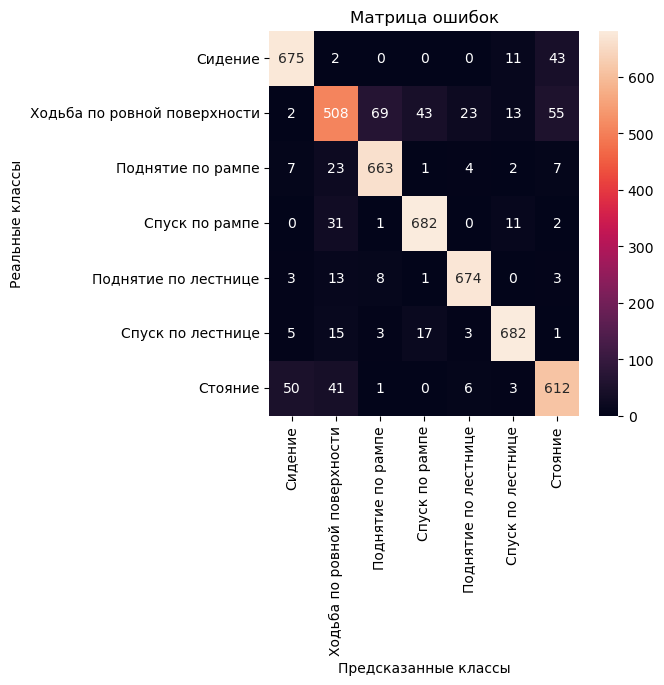

In [26]:
trainer.run(train_loader, max_epochs=250)

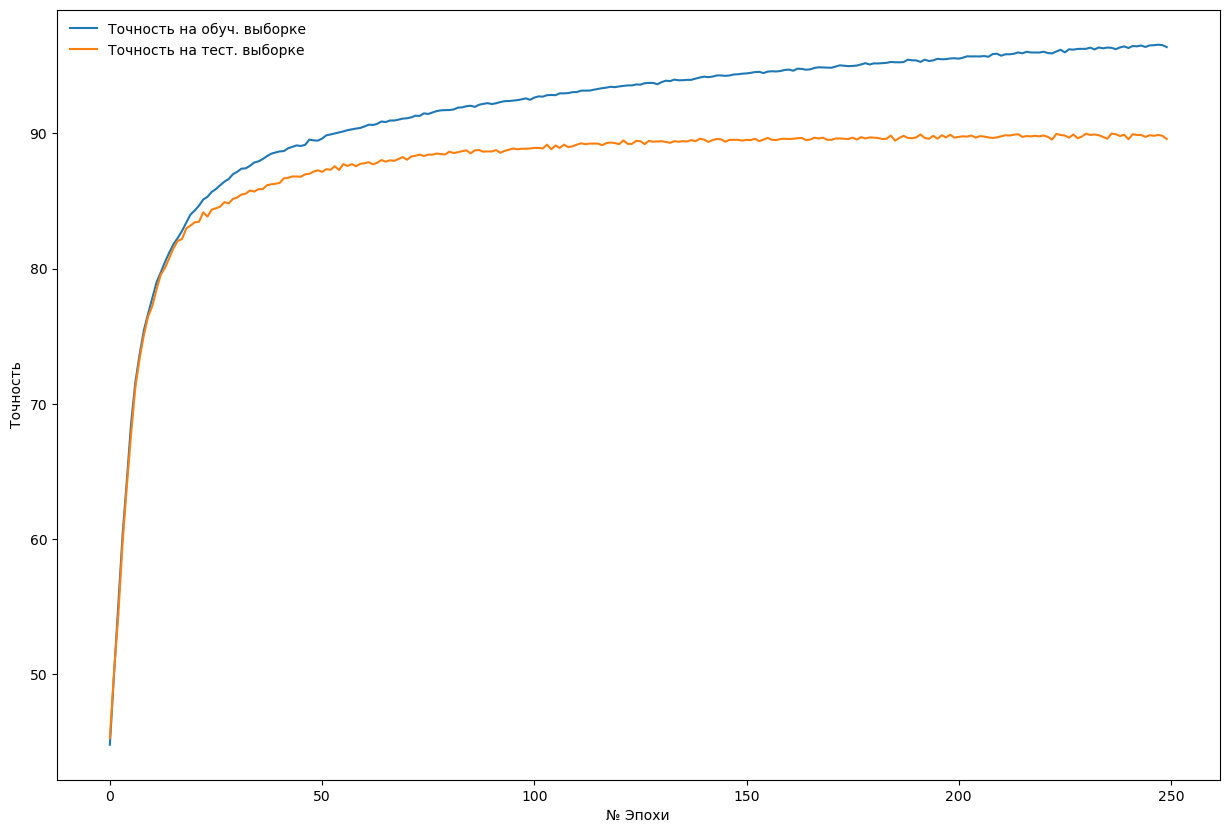

In [27]:
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(training_history['accuracy'],label="Точность на обуч. выборке")
plt.plot(test_history['accuracy'],label="Точность на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Точность')
plt.legend(frameon=False)
#plt.savefig('Accuracy_50_001_50.jpeg')
plt.show()


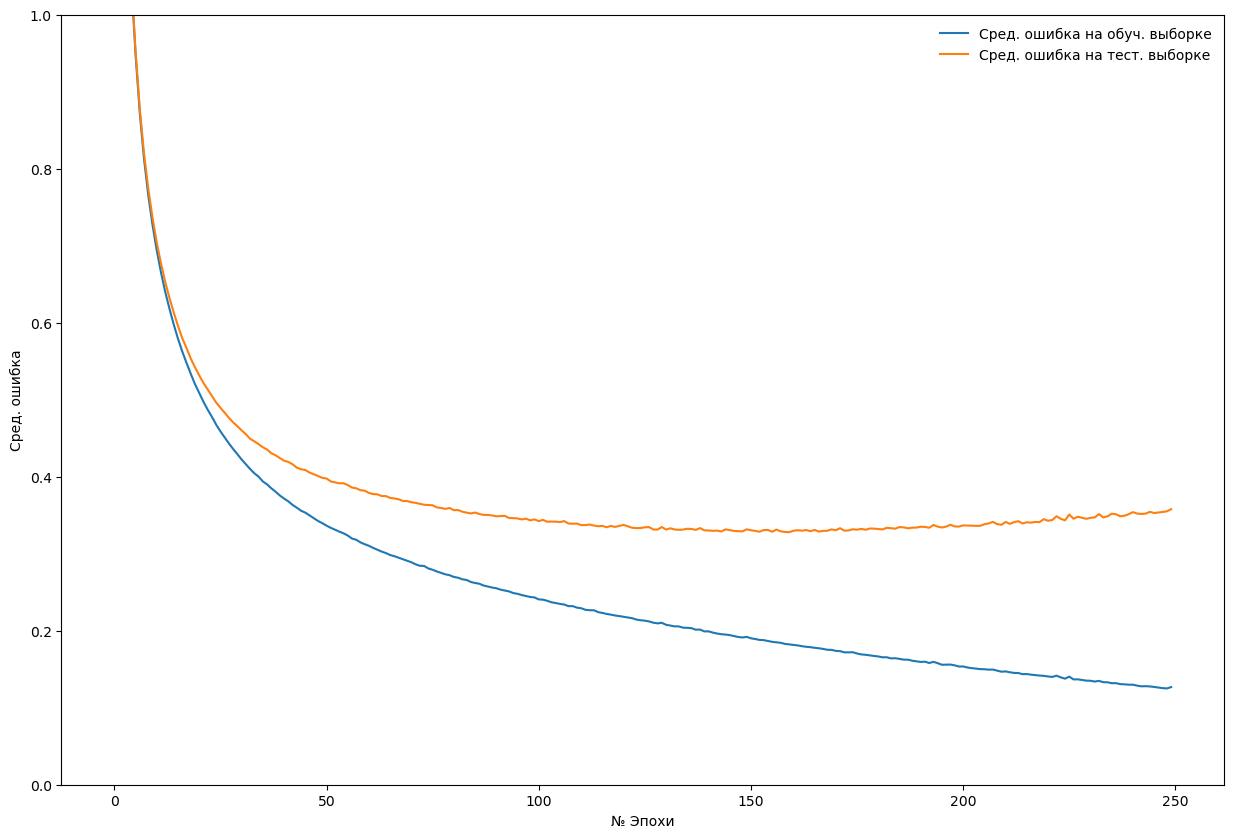

In [28]:
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(training_history['loss'],label="Сред. ошибка на обуч. выборке")
plt.plot(test_history['loss'],label="Сред. ошибка на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylim(0,1)
plt.ylabel('Сред. ошибка')
plt.legend(frameon=False)
#plt.savefig('Loss_50_001_50.jpeg')
plt.show()


In [ ]:
test_evaluator.run(test_loader)
metrics = test_evaluator.state.metrics
cm = metrics['cm']
cm = cm.numpy()
cm = cm.astype(int)
classes = ['Сидение', 'Ходьба по ровной поверхности', 'Поднятие по рампе', 'Спуск по рампе', 'Поднятие по лестнице', 'Спуск по лестнице', 'Стояние']
fig, ax = plt.subplots(figsize=(6,6))  
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d")
# labels, title and ticks
ax.set_xlabel('Предсказанные классы')
ax.set_ylabel('Реальные классы') 
ax.set_title('Матрица ошибок') 
ax.xaxis.set_ticklabels(classes,rotation=90)
ax.yaxis.set_ticklabels(classes,rotation=0)